<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Random_Forest_on_correlation_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 5.86 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [49]:
!pwd

/content/pandas-technical-indicators


In [50]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators/pandas-technical-indicators


In [51]:

# Import libraries
import os
import sys
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [52]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime
plt.style.use('seaborn-white')

In [54]:
#@title Default title text
def moving_average(df, n):
    """Calculate the moving average for the given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df.iloc[:,4].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


def momentum(df, n):
    """
    
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df.iloc[:,4].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df

def bollinger_bands(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df
def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df
def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df
def vortex_indicator(df, n,name='data_0'):
    """Calculate the Vortex Indicator for given data.
    
    Vortex Indicator described here:
        http://www.vortexindicator.com/VFX_VORTEX.PDF
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR = [0]
    df.reset_index(inplace=True)
    while i < df.index[-1]:
        Range = max(df.iloc[i + 1, 2], df.iloc[i, 4]) - min(df.iloc[i + 1, 3], df.iloc[i, 4])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.iloc[i + 1, 2] - df.iloc[i, 3]) - abs(df.iloc[i + 1, 3] - df.iloc[i, 2])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_'+name+ str(n))
    df = df.join(VI)
    df=df.set_index("date") 	
    return df
def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    df.reset_index(inplace=True)	
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    df= df.set_index('Date')	
    return df                

In [55]:
data_p = pd.read_csv('/content/NSE_NIFTY.csv')

In [56]:

data_p['date']=data_p.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))


In [57]:
data_p.shape

(2557, 12)

In [58]:

del data_p['time']
del data_p['Volume']
del data_p['Volume MA']

In [59]:
data=data_p[:1000]
real=data_p[1000:]

In [60]:
data.tail(2)

,open,high,low,close,"INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close",date
998,8181.5498,8254.9502,8089.7998,8235.4502,20.545000,21.432501,18.097500,20.684999,13-05-2015
999,8232.4502,8236.2500,8137.2998,8224.2002,20.684999,21.905001,19.815001,20.700001,14-05-2015


In [61]:
real.tail(2)

,open,high,low,close,"INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close",date
2555,16627.949,16683.699,16603.4,16636.900,13.4975,14.195,12.1125,13.5375,26-08-2021
2556,16642.551,16722.051,16565.6,16705.199,13.5375,13.760,12.9400,13.4050,27-08-2021


In [62]:
data= data.set_index('date')
#real.rename(columns={'date':'Date'},inplace=True)
real=real.set_index('date')

In [63]:
data_0=data.iloc[:,0:4]

data_1=data.iloc[:,4:8]


    

# Input

In [64]:
# INPUT .........

#  ********************************* #

t=2
days_out=14


#  ********************************* #

In [65]:
def get_indicators(data_0,data_1,days_out,t=1,type='Cu'):

    data_0 = vortex_indicator(data_0.iloc[:,0:4] , days_out,name='data_0_')
    data_1 = vortex_indicator(data_1.iloc[:,0:4] , days_out,name='data_1_')
    
    data_f=pd.concat([data_0,data_1],axis=1)
    
    return data_f

In [66]:
train_0=int(len(data_0)*.75)
df_train_0= data_0[:train_0]
df_test_0= data_0[train_0+50:]
train_1=int(len(data_1)*.75)
df_train_1= data_1[:train_1]
df_test_1= data_1[train_1+50:]


In [67]:
df_train = get_indicators(df_train_0,df_train_1,days_out,1)
df_test= get_indicators(df_test_0,df_test_1,days_out,1)

In [68]:
df_train.shape , df_test.shape

((750, 10), (200, 10))

In [69]:
df_train.tail(5)

,open,high,low,close,Vortex_data_0_14,"INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close",Vortex_data_1_14
date,,,,,,,,,,
29-04-2014,6769.0000,6779.7002,6708.6499,6715.2500,0.007284,31.385000,32.435001,30.492500,31.049999,0.260027
30-04-2014,6724.9502,6780.1499,6656.7998,6696.3999,0.002189,31.049999,31.462500,30.025000,30.592501,0.258943
02-05-2014,6709.9502,6737.6499,6689.5000,6694.7998,0.043852,30.592501,33.422501,29.182501,33.055000,0.238776
05-05-2014,6681.6499,6741.0498,6680.4502,6699.3501,-0.105480,33.055000,35.305000,30.987499,34.187500,0.207639
06-05-2014,6719.2500,6743.4502,6701.8999,6715.2998,-0.166982,34.187500,34.302502,31.365000,33.267502,0.197158


In [70]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()

In [71]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [72]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [73]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=80,min_samples_leaf=2,max_features='auto', min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [74]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  91.39784946236558


In [75]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100


Vortex_data_0_14        66.250485
Vortex_data_1_14         6.819609
close                    5.200376
low                      4.085136
high                     3.919593
open                     3.736690
INDIAVIX, NSE: Low       2.740405
INDIAVIX, NSE: High      2.627457
INDIAVIX, NSE: Close     2.388666
INDIAVIX, NSE: Open      2.231582
dtype: float64

In [76]:
feature_imp

Vortex_data_0_14        0.662505
Vortex_data_1_14        0.068196
close                   0.052004
low                     0.040851
high                    0.039196
open                    0.037367
INDIAVIX, NSE: Low      0.027404
INDIAVIX, NSE: High     0.026275
INDIAVIX, NSE: Close    0.023887
INDIAVIX, NSE: Open     0.022316
dtype: float64

In [77]:
features=X_train.columns

In [78]:
#feats=['Vortex_data_1_24','Vortex_data_2_24','INDIAVIX, NSE: High','INDIAVIX, NSE: Close']

In [79]:
real.tail(2)

,open,high,low,close,"INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close"
date,,,,,,,,
26-08-2021,16627.949,16683.699,16603.4,16636.900,13.4975,14.195,12.1125,13.5375
27-08-2021,16642.551,16722.051,16565.6,16705.199,13.5375,13.760,12.9400,13.4050


In [80]:
real_0=real.iloc[:,0:4]
real_1=real.iloc[:,4:8]


In [81]:
df_real = get_indicators(real_0,real_1,days_out,1)

In [82]:
price_data_new = df_real.copy()

In [83]:
# Group by the `Symbol` column, then grab the `Close` column.
close_groups = df_real['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
price_data_new['Signal_Flag'] = close_groups
price_data_new = price_data_new.dropna()

In [84]:
ppp =price_data_new.reset_index()

In [85]:
ppp.tail(2)

,date,open,high,low,close,Vortex_data_0_14,"INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close",Vortex_data_1_14,Signal_Flag
1541,26-08-2021,16627.949,16683.699,16603.4,16636.900,0.392065,13.4975,14.195,12.1125,13.5375,0.063368,1.0
1542,27-08-2021,16642.551,16722.051,16565.6,16705.199,0.383877,13.5375,13.760,12.9400,13.4050,0.073185,1.0


In [86]:

pred = pd.DataFrame(rand_frst_clf.predict(price_data_new[features]))
pred = pd.concat([pred , ppp.date,ppp['close']],axis=1)
pred.columns=['pred','date','Close']
pred= pred.set_index('date')

In [87]:
l=len(pred)

In [88]:
l

1543

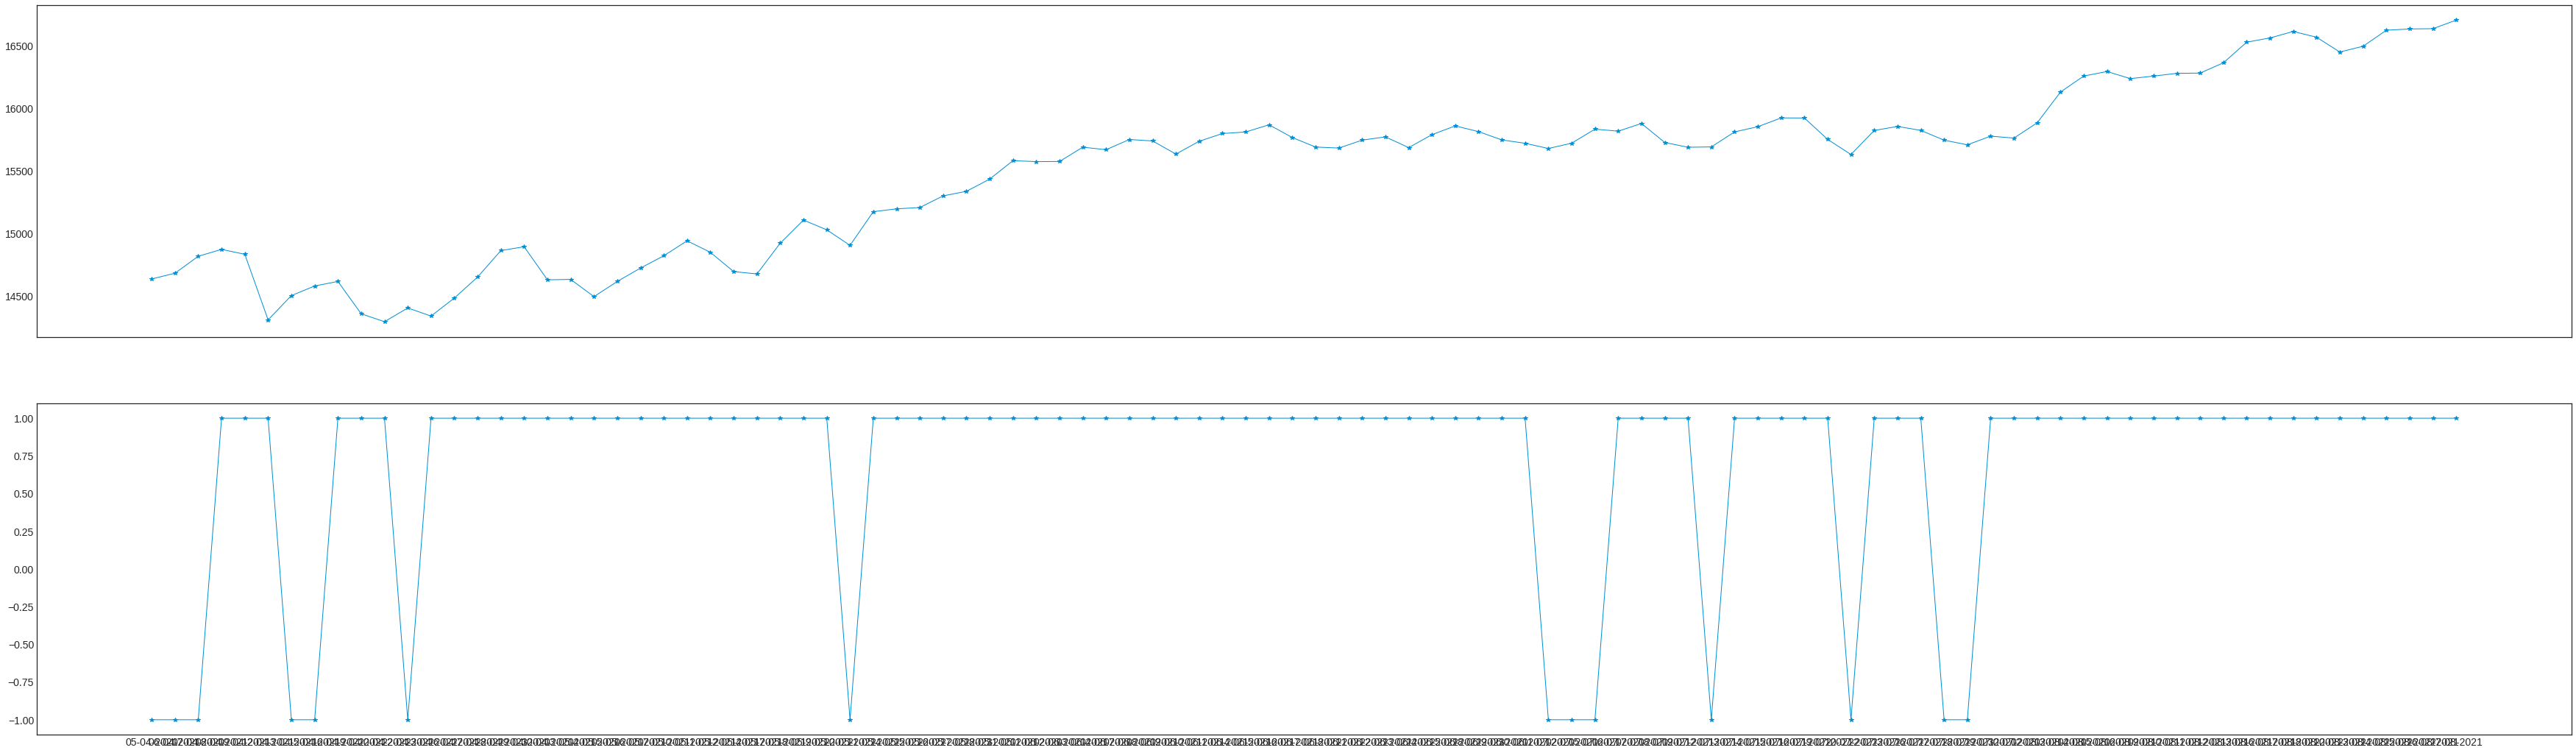

In [89]:
fig, ax = plt.subplots(2,1,figsize=(55,17),sharex=True)
ax[0].plot(df_real.index.values[-100:],df_real['close'].values[-100:],'*-',linewidth=1 )
ax[1].plot(df_real.index.values[-100:],pred.pred.values[-100:],'*-',linewidth=1 )
#plt.xticks(fontsize=12, rotation=90)
plt.show()

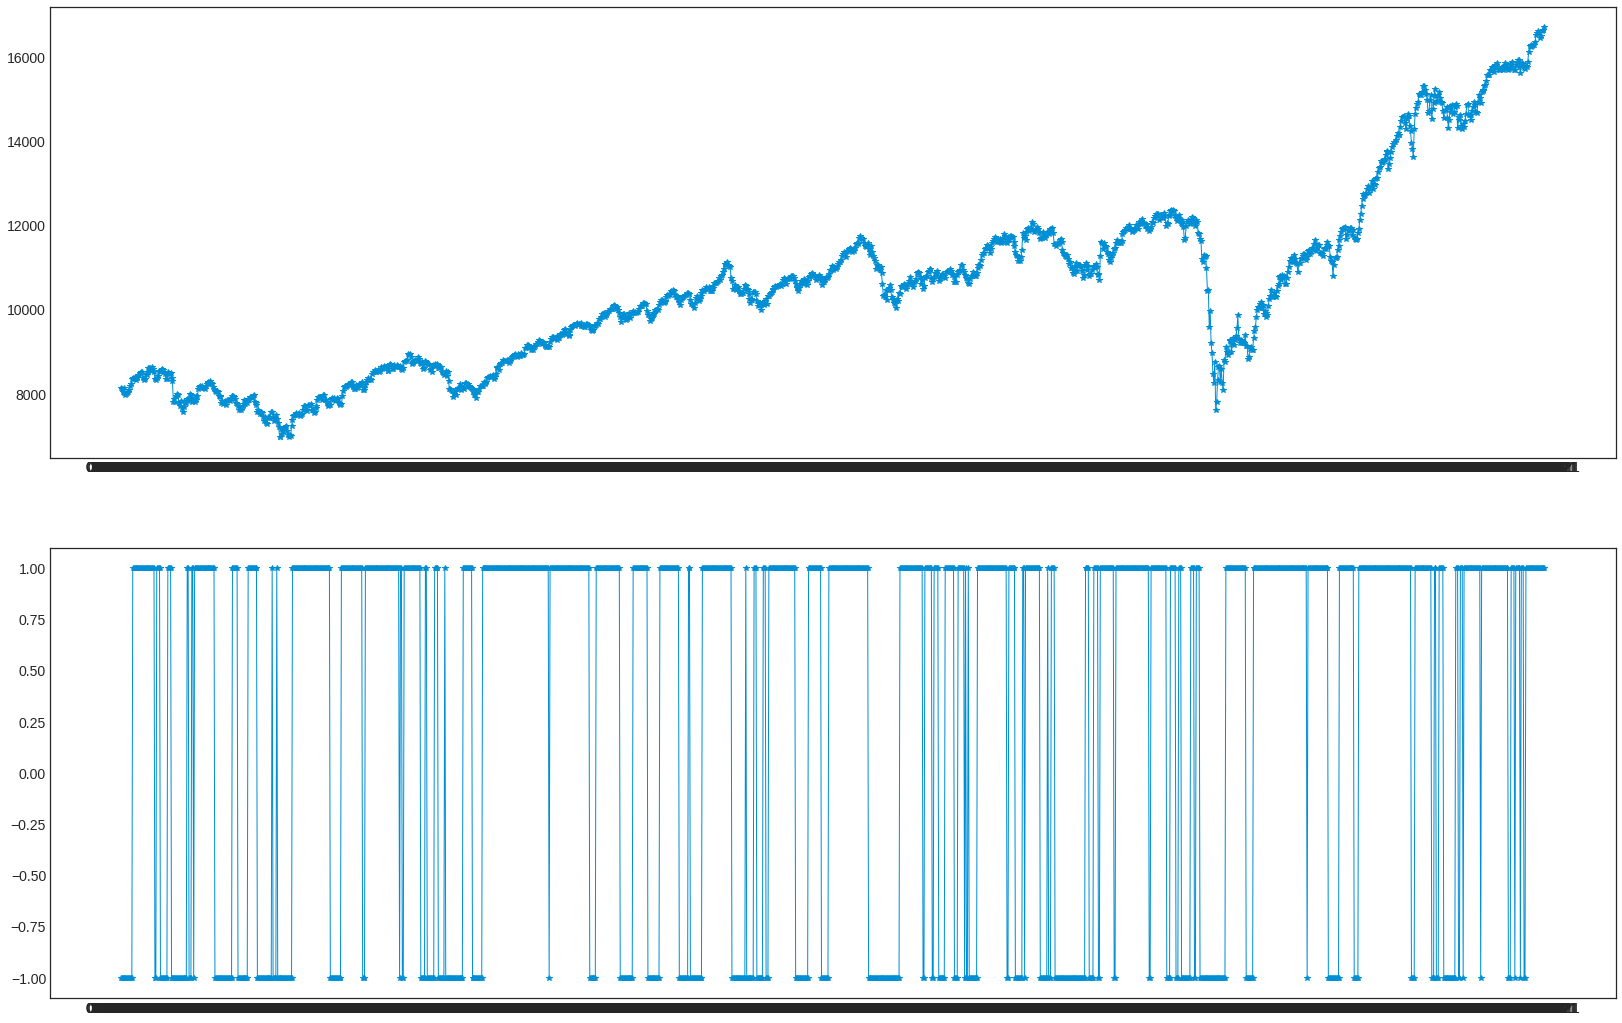

In [90]:
fig, ax = plt.subplots(2,1,figsize=(25,17))
ax[0].plot(df_real.index.values[-l:],df_real['close'].values[-l:],'*-',linewidth=1 )
ax[1].plot(df_real.index.values[-l:],pred.pred.values[-l:],'*-',linewidth=1 )
#plt.xticks(fontsize=12, rotation=90)
plt.show()

In [91]:
pred=pred.reset_index()

In [92]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['pred']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['pred']==-1), 0, 1)

In [95]:
# saving the dataframe
pred.to_csv('/content/rf_vix.csv')

In [96]:
df_real['50_EMA'] = df_real['close'].rolling(50).mean()
df_real['100_EMA'] = df_real['close'].rolling(100).mean()

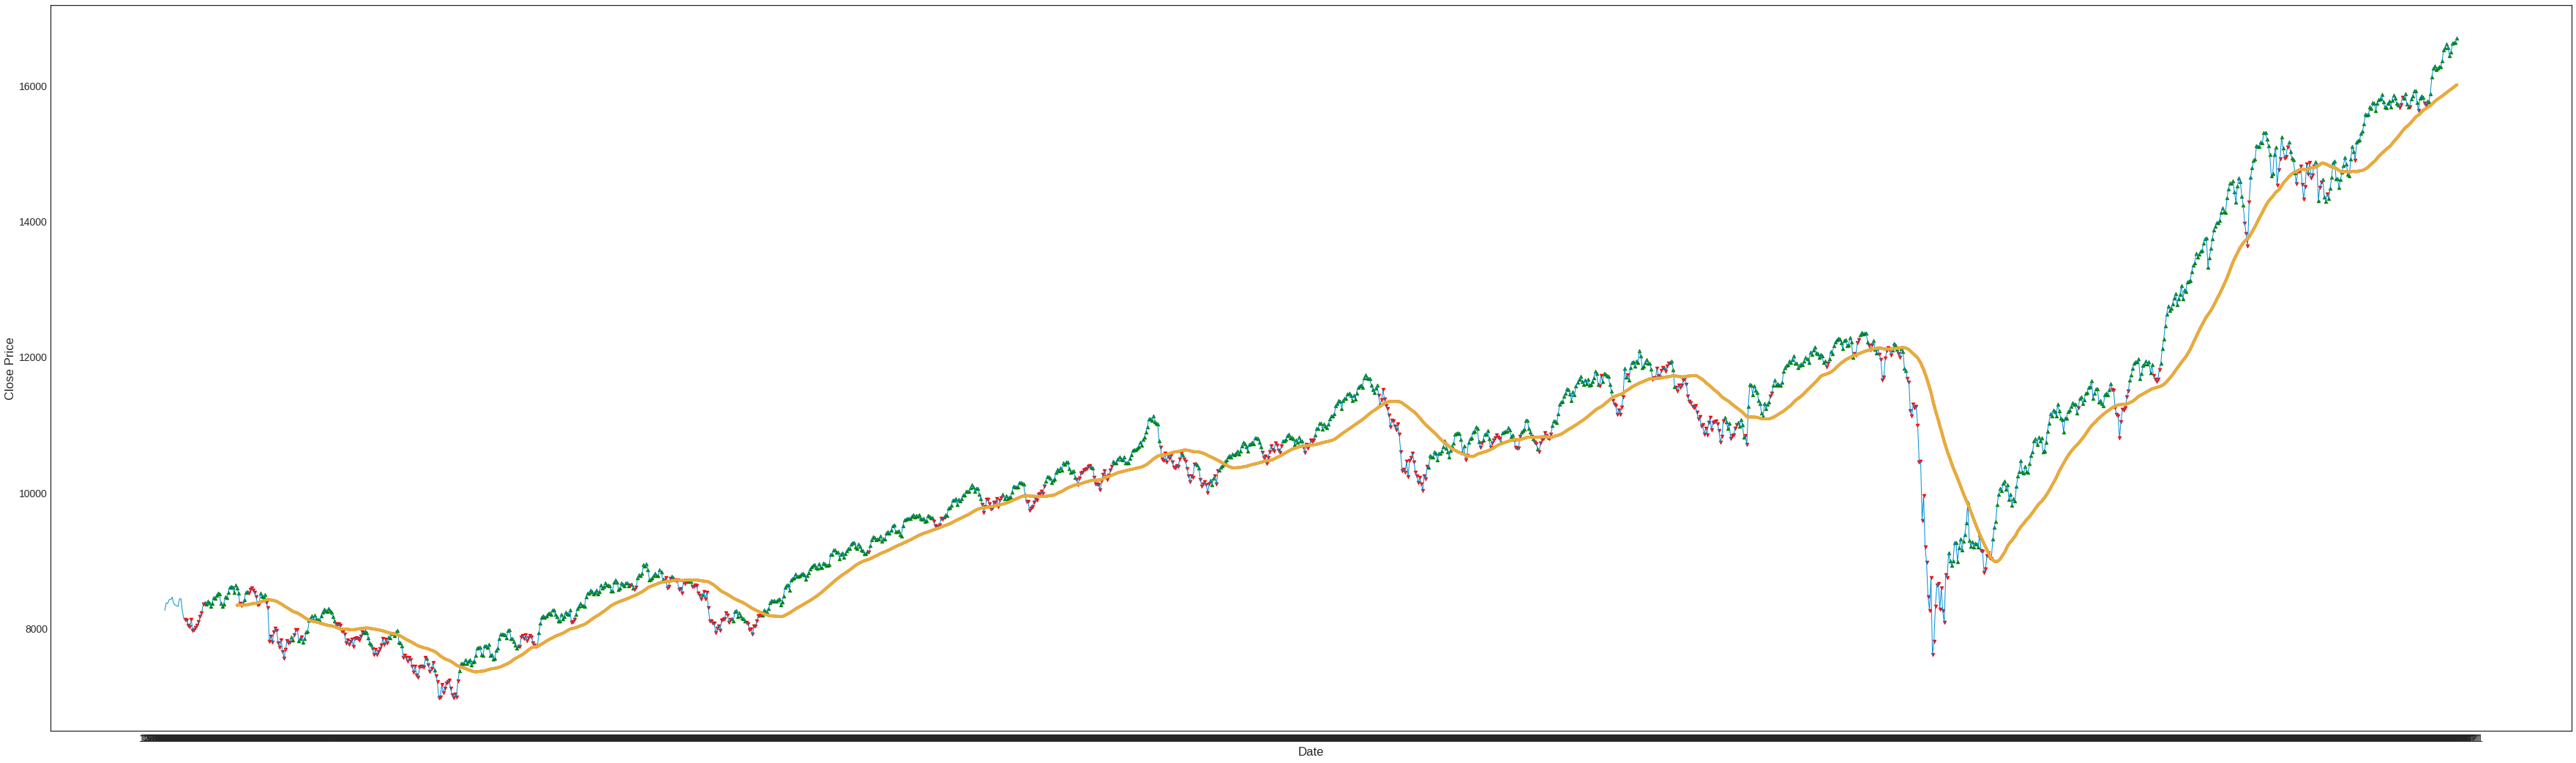

In [97]:
plt.figure(figsize=(55,17))
## plotting the buy and sell signals on graph
plt.plot(df_real.index.values[:],df_real['close'].values[:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=25, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=25, marker="v")
plt.plot(df_real.index.values[-l:],df_real['50_EMA'].values[-l:])
plt.plot(df_real.index.values[-l:],df_real['50_EMA'].values[-l:])
## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
#plt.title('AD Nifty price with buy and sell signal ' ) 
#plt.xticks(fontsize=1, rotation=90)
#plt.savefig('a.png')
plt.show();